<a href="https://colab.research.google.com/github/shivanshudwivedi/Deep-Learning/blob/main/Notebook_12_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning for Facial Feature Recognition**

# **Code to check correct version of TensorFlow in Google Colab**

In [ ]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except:
    print("Note: not using Google CoLab")
    COLAB = False


Note: using Google CoLab
Wed May  4 19:25:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                               

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30


In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving dc.jpg to dc.jpg


In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving rdr.jpeg to rdr.jpeg


In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2


--2022-05-04 19:33:01--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  31.2MB/s    in 0.2s    

2022-05-04 19:33:01 (31.2 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [ ]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 14.00 MiB/s, done.
Resolving deltas: 100% (57/57), done.
     |████████████████████████████████| 108 kB 5.0 MB/s 


In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

In [ ]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)

(658, 580) (687, 609)
(570, 577) (599, 606)
(330, 577) (359, 606)
(420, 576) (449, 605)
(495, 763) (524, 792)


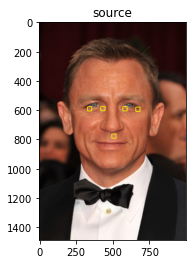

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

In [ ]:
def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)

  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  # Calculate the size of the face
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  # Consider the aspect ratio
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  # Adjust to the offset used by StyleGAN2
  crop1 = left_eye2[0] - 385
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

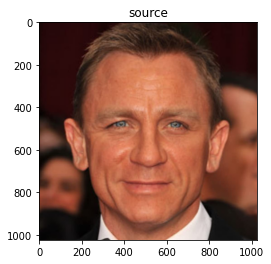

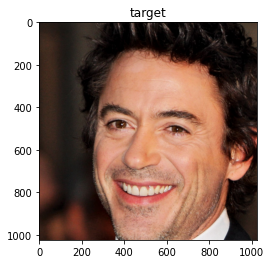

True

In [ ]:
# The following code will preprocess and crop your images. If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background. If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

# Note this step will take between 4 - 7 minutes depending on your GPU


Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.61 loss 24567.16
step    2/1000: dist 0.57 loss 27640.47
step    3/1000: dist 0.63 loss 27167.01
step    4/1000: dist 0.63 loss 26253.12
step    5/1000: dist 0.57 loss 24956.87
step    6/1000: dist 0.55 loss 23353.69
step    7/1000: dist 0.60 loss 21512.51
step    8/1000: dist 0.57 loss 19485.88
step    9/1000: dist 0.55 loss 17339.13
step   10/1000: dist 0.57 loss 15139.44
step   11/1000: dist 0.49 loss 12948.90
step   12/1000: dist 0.57 loss 10818.38
step   13/1000: dist 0.55 loss 8801.96
step   14/1000: dist 0.44 loss 6945.79
step   15/1000: dist 0.46 loss 5315.12
step   16/1000: dist 0.48 loss 3970.79
step   17/1000: dist 0.45 loss 2943.87
step   18/1000: dist 0.46 loss 2215.01
step   19/1000: dist 0

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

# Note this step will take between 3 - 7 minutes depending on your GPU

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.61 loss 24567.16
step    2/1000: dist 0.56 loss 27640.46
step    3/1000: dist 0.60 loss 27166.98
step    4/1000: dist 0.62 loss 26253.11
step    5/1000: dist 0.60 loss 24956.89
step    6/1000: dist 0.57 loss 23353.71
step    7/1000: dist 0.57 loss 21512.47
step    8/1000: dist 0.58 loss 19485.89
step    9/1000: dist 0.61 loss 17339.19
step   10/1000: dist 0.60 loss 15139.47
step   11/1000: dist 0.56 loss 12948.97
step   12/1000: dist 0.61 loss 10818.42
step   13/1000: dist 0.60 loss 8802.01
step   14/1000: dist 0.53 loss 6945.87
step   15/1000: dist 0.52 loss 5315.17
step   16/1000: dist 0.56 loss 3970.86
step   17/1000: dist 0.51 loss 2943.95
step   18/1000: dist 0.52 loss 2215.06
step   19/1000: dist 0

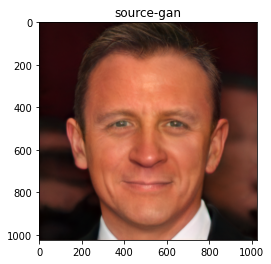

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

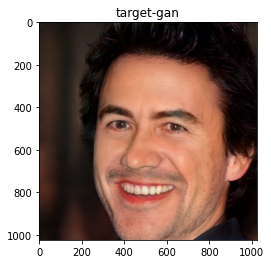

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1

  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [ ]:
from google.colab import files
files.download("movie.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Transfer Learning for Style Transfer**

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for source.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    base_image_path = f"source{ext}"
    open(base_image_path, 'wb').write(v)

Saving source.jpeg to source.jpeg


In [ ]:
uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload exactly 1 file for target.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    style_reference_image_path = f"style{ext}"
    open(style_reference_image_path, 'wb').write(v)

Saving style_image.jpeg to style_image.jpeg


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

result_prefix = "generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

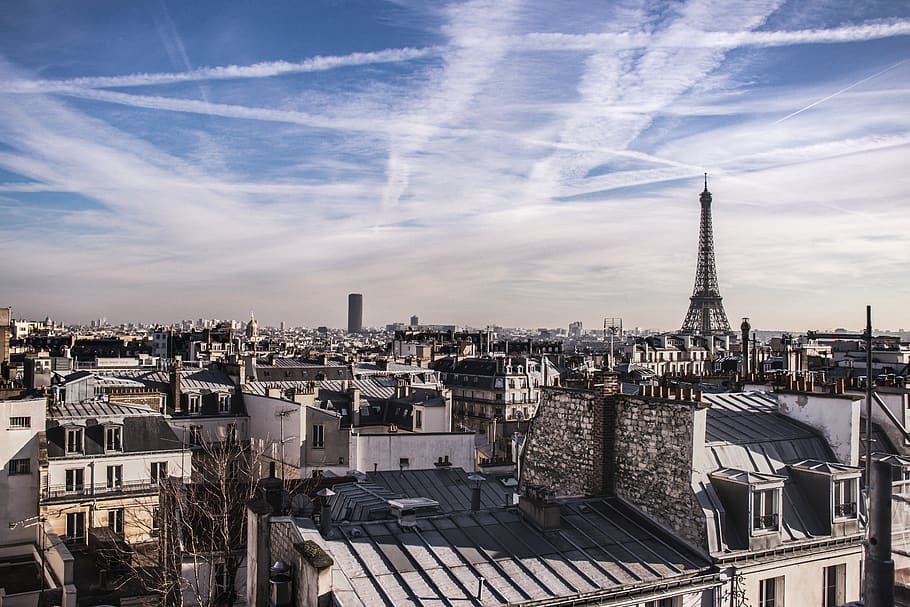

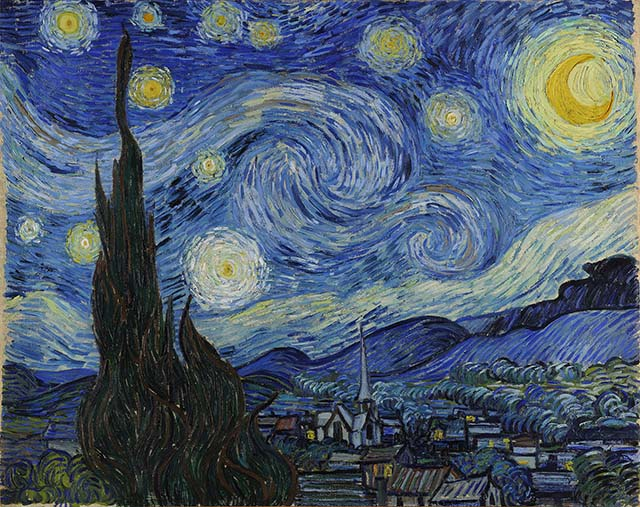

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

In [ ]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [ ]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [ ]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2" # The layer to use for the content loss.

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    loss = tf.zeros(shape=())     # Initialize the loss

    layer_features = features[content_layer_name]     # Add content loss
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )

    for layer_name in style_layer_names:     # Add style loss
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [ ]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)

# Note this step will take between 4 - 10 minutes depending on your GPU

Iteration 100: loss=5661.25
Iteration 200: loss=3828.90
Iteration 300: loss=3219.46
Iteration 400: loss=2914.32
Iteration 500: loss=2727.73
Iteration 600: loss=2600.08
Iteration 700: loss=2506.59
Iteration 800: loss=2434.53
Iteration 900: loss=2377.12
Iteration 1000: loss=2330.14
Iteration 1100: loss=2290.89
Iteration 1200: loss=2257.52
Iteration 1300: loss=2228.73
Iteration 1400: loss=2203.57
Iteration 1500: loss=2181.38
Iteration 1600: loss=2161.69
Iteration 1700: loss=2144.06
Iteration 1800: loss=2128.18
Iteration 1900: loss=2113.81
Iteration 2000: loss=2100.76
Iteration 2100: loss=2088.85
Iteration 2200: loss=2077.95
Iteration 2300: loss=2067.92
Iteration 2400: loss=2058.67
Iteration 2500: loss=2050.12
Iteration 2600: loss=2042.19
Iteration 2700: loss=2034.82
Iteration 2800: loss=2027.96
Iteration 2900: loss=2021.57
Iteration 3000: loss=2015.61
Iteration 3100: loss=2010.03
Iteration 3200: loss=2004.81
Iteration 3300: loss=1999.90
Iteration 3400: loss=1995.28
Iteration 3500: loss=19

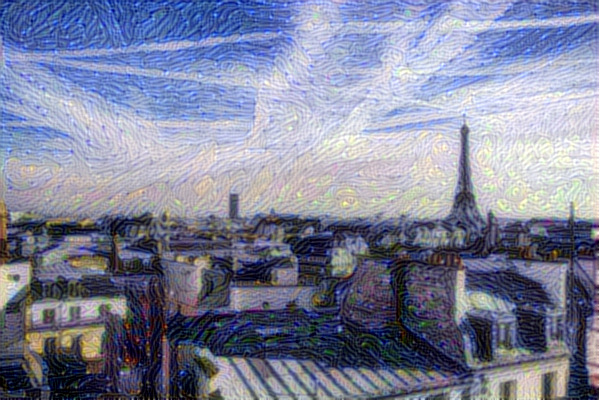

In [ ]:
display(Image(result_prefix + "_at_iteration_4000.png"))

In [ ]:
from google.colab import files
files.download(result_prefix + "_at_iteration_4000.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Class Exercise 6**

In this class exercise we will explore the following topics:
- Hugging Face Library
- Natural Language Processing

In [ ]:
# Import and Install necessary libraries
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets


     |████████████████████████████████| 4.0 MB 6.3 MB/s 
     |████████████████████████████████| 77 kB 3.2 MB/s 
     |████████████████████████████████| 880 kB 43.7 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=dd01539785b2234714c5712981166742c016232dbcb9741baf5adc67805381fb
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 136 kB 51.8 MB/s 
     |████████████████████████████████| 212 kB 51.6 MB/s 
     |███████████████████████████████

Please complete the following tasks:
- Task 1: Classify Emotion from Given Text.
- Task 2: Generate Summary from Given Text.
- Task 3: Generate Text from Given Text.

In [ ]:
import pandas as pd
from transformers import pipeline
from urllib.request import urlopen

**Task 1: Classify Emotion from Given Text**

In the class lecture we saw an example of binary emotion classifcation from text into positive/negative classes.

- Classify given text classification into one of six basic emotions (anger, fear, surprise, joy, sadness, disgust)
- Use specified model `model = 'j-hartmann/emotion-english-distilroberta-base'`
- [Learn more about the model](https://github.com/j-hartmann/emotion-english-distilroberta-base)

In [ ]:
# Read sample text, a poem
URL = "https://people.ucsc.edu/~cchakrab/data/sonnet_18.txt"
f = urlopen(URL)
text = f.read().decode("utf-8")
size = len(text)                                               # For this model text size must be multiple of 512
model = 'j-hartmann/emotion-english-distilroberta-base'

# Start your code here


# Sample Output

Size of input 679
Sample Text:
Sonnet 18 original text
William Shakespeare

Shall I compare thee to a summer's day?
Thou art mo


Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

,label,score
0,fear,0.789464


**Task 2: Generate summary from given text.**

- Generate a 50 word summary from given text.
- Use specified model. `model = 'bhuvaneswari/t5-small-text_summarization'`
- [Learn more about the model](https://huggingface.co/bhuvaneswari/t5-small-text_summarization)


In [ ]:
# Task 2
text2 = """
Solid state refers to electronic circuitry that is built entirely of semiconductors. The term was originally used to define those electronics, such as a transistor radio that used semiconductors rather than vacuum tubes in its construction.
Most electronics today are built around semiconductors and chips. A solid state drive uses, as its primary storage medium, semiconductors rather than the magnetic platters of a conventional hard drive.
Solid state drives and USB flash drives use the same type of non-volatile memory chips that retain information when there is no power. The difference is in the form factor and capacity of the drives. While a flash drive is designed to be external to the computer system, an SSD is designed to reside inside the computer in place of a more traditional hard drive.
Solid state drives offer several advantages over magnetic hard drives. First, the SSD does not have moving parts. While a magnetic drive uses drive motors to spin the magnetic platters and the drive heads, all the storage on a solid state drive is handled by flash memory chips.
The power usage is a key role in the use of solid-state drives in portable computers. Because there is no power draw for the motors, the drive uses less energy than the regular hard drive. The industry has taken steps to address this discrepancy with drives spinning down and the development of hybrid hard drives. However, both of these use more power. The solid state drive consistently draws less power than the magnetic and hybrid hard drives.
Because the drive does not spin the drive platter or move drive heads, the data reads from the drive more quickly. Hybrid hard drives tend to mitigate the speed aspect when it comes to frequently used drives. Similarly, Intel's new Smart Response Technology is a similar method of caching on a small solid state drive to produce similar results.
"""
model = 'bhuvaneswari/t5-small-text_summarization'

# Start your code here


# Sample Output

The term "solid state" is a term used to describe electronics that are built entirely of semiconductors and chips, but it has been used in the United States for decades.


**Task 3: Generate Text from Given Text.**

- Use the given text as seed to generate a 250 word article.
- Use specified model. `# model = 'distilgpt2'` <br/>
- [Learn more about the model](https://huggingface.co/distilgpt2)

In [ ]:
Task 3
from urllib.request import urlopen

text3 = """
The dog has been selectively bred over millennia for various behaviors, sensory capabilities, and physical attributes.
Dog breeds vary widely in shape, size, and color. They perform many roles for humans, such as hunting, herding, pulling loads, protection, assisting police and the military, companionship, therapy, and aiding disabled people. Over the millennia, dogs became uniquely adapted to human behavior, and the human-canine bond has been a topic of frequent study. This influence on human society has given them the sobriquet of mans best friend
"""

model = 'distilgpt2'

# Start your code here


# Sample Output

Fears of violence can be high in humans. In the wake of these physical and psychological challenges, people often feel like they might become dangerous and aggressive.
The dog is usually treated with drugs used for its specific health or welfare. 
The most common drugs are acetaminophen, a medication that causes high blood pressure, hyperkinesia, or a feeling of euphoria. One commonly used prescription is ibuprofen, which causes high blood pressure. 
In addition, the use of other medications causes symptoms, headaches, headache and a fever. 
This is a commonly used prescription for dogs. People with schizophrenia tend to be more prone to abuse of mental


**What to submit**
- Upon completion of the exercise, inside Colab/Jupyter, go to File ->Download -> Download .ipynb
- Check the downloaded notebook file has an extension of .ipynb.
- Please upload your submission to Moodle.

In [ ]:
print('Done.')

Done.
